In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})

from dedalus.core.operators import SpectralOperator1D

class ComplexFourierPseudodifferential(SpectralOperator1D):

    input_basis_type = d3.ComplexFourier
    subaxis_dependence = [True]
    subaxis_coupling = [False]

    def __init__(self, operand, coord, out=None):
        super().__init__(operand, out=out)
        # SpectralOperator requirements
        self.coord = coord
        self.input_basis = operand.domain.get_basis(coord)
        self.output_basis = self.input_basis
        self.first_axis = coord.axis
        self.last_axis = coord.axis
        self.axis = coord.axis
        # LinearOperator requirements
        self.operand = operand
        # FutureField requirements
        self.domain = operand.domain.substitute_basis(self.input_basis, self.output_basis)
        self.tensorsig = operand.tensorsig
        self.dtype = operand.dtype

    @classmethod
    def _group_matrix(cls, group, input_basis, output_basis):
        # Rescale group (native wavenumber) to get physical wavenumber
        k = group / input_basis.COV.stretch
        # dx exp(1j*k*x) = 1j * k * exp(1j*k*x)
        return np.array([[cls.k_func(k)]])


class abs_m_cls(ComplexFourierPseudodifferential):

    name = "abs_m"

    @classmethod
    def k_func(cls, k):
        return abs(k)

    def new_operand(self, operand, **kw):
        if operand == 0:
            return 0
        return abs_m_cls(operand,  self.coord, **kw)

Here the time dependendent IVP problem we're looking to iterate is
$$ \nabla\cdot\Big(\frac{1}{h}\nabla\frac{\partial \psi}{\partial t}\Big)+f\hat{\mathbf{k}}\cdot \nabla\psi\times\nabla\Big(\frac{1}{h}\Big) = -\frac{\kappa}{h}\nabla\cdot\Big(\frac{1}{h}\nabla\psi\Big)+W_{Ek}\exp(ift \omega_\textrm{force})$$
which is the system considered previously with no assumed form to the temporal dependence (no ansatz) and the inclusion of both dissipation and ekman forcing as some frequency or range of frequencies $\omega_\textrm{force}$.

This system should then be expanded out prior to implementation in dedalus, it will be kind of a lot
$$\frac{1}{h}\psi_{rrt}+\frac{1}{hr^2}\psi_{\theta\theta t}+\big(\frac{1}{h}\big)_r \psi_{rt}+\frac{1}{r^2}\big(\frac{1}{h}\big)_\theta \psi_{\theta t} + \frac{f}{r}\big(\frac{1}{h}\big)_\theta \psi_{r}- \frac{f}{r}\big(\frac{1}{h}\big)_r \psi_{\theta} = -\frac{\kappa}{h}\Big(\frac{1}{h}\psi_{rr}+\frac{1}{hr^2}\psi_{\theta\theta}+\big(\frac{1}{h}\big)_r\psi_r+\frac{1}{r^2}\big(\frac{1}{h}\big)_\theta\psi_\theta\Big)+W_{Ek}\exp(ift\omega_\textrm{force}).$$

And we'll need to include the following boundary conditions,
$$\psi(r=R_i)=0$$
$$\textrm{Dirichlet to Neumann at }r = R_o$$ 
and tau terms (second order).

I think it will be easier to just start with the island configuration (no ridge)...

In [41]:
## variable parameters 
Ri      = 0.5
Ro      = 6
Nθ      = 64;
Nr      = 64;
ω_force = -0.27 # maximum magnitude frequenccy for the island in this case (analytical)
κ       = 1e-3
ek_mag  = 1
Hmin_island = 0.25;

## fixed and dependent parameters 
α = np.log(Hmin_island)/(2*np.log(Ri));
coriolis = 1e-4

In [42]:
## time evolution
# literally no idea what would be good here...
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125

In [43]:
## basis
coords = d3.CartesianCoordinates('θ', 'r')
dist = d3.Distributor(coords, dtype=np.complex128)
θ_basis = d3.Fourier(coords['θ'], Nθ, (0, 2*np.pi), dtype=np.complex128)
r_basis = d3.Chebyshev(coords['r'], Nr, (Ri, Ro))

In [44]:
## fields
ψ    = dist.Field(name='ψ', bases=(θ_basis, r_basis))
tau1 = dist.Field(name='tau1', bases=θ_basis)
tau2 = dist.Field(name='tau2', bases=θ_basis)
t    = dist.Field(name='t')

In [45]:
## substitutions
θ, r = dist.local_grids(θ_basis, r_basis)
# rinv = dist.Field(bases=r_basis); 
# rinv['g'] = r**(-1)
lift_basis = r_basis.derivative_basis(2)
tau_terms = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)

R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

# bathymetry
hisland = R**(2*α) 
hisland[hisland>1] = 1
hinv = dist.Field(name='hinv',bases=(θ_basis,r_basis))
hinv['g'] = hisland**(-1)

ζ = dist.Field(name='ζ', bases=(θ_basis, r_basis))
ζ = d3.div(hinv*d3.grad(ψ))


In [46]:
ψ

<Field 5149436672>

In [47]:
hinv

<Field 5150093088>

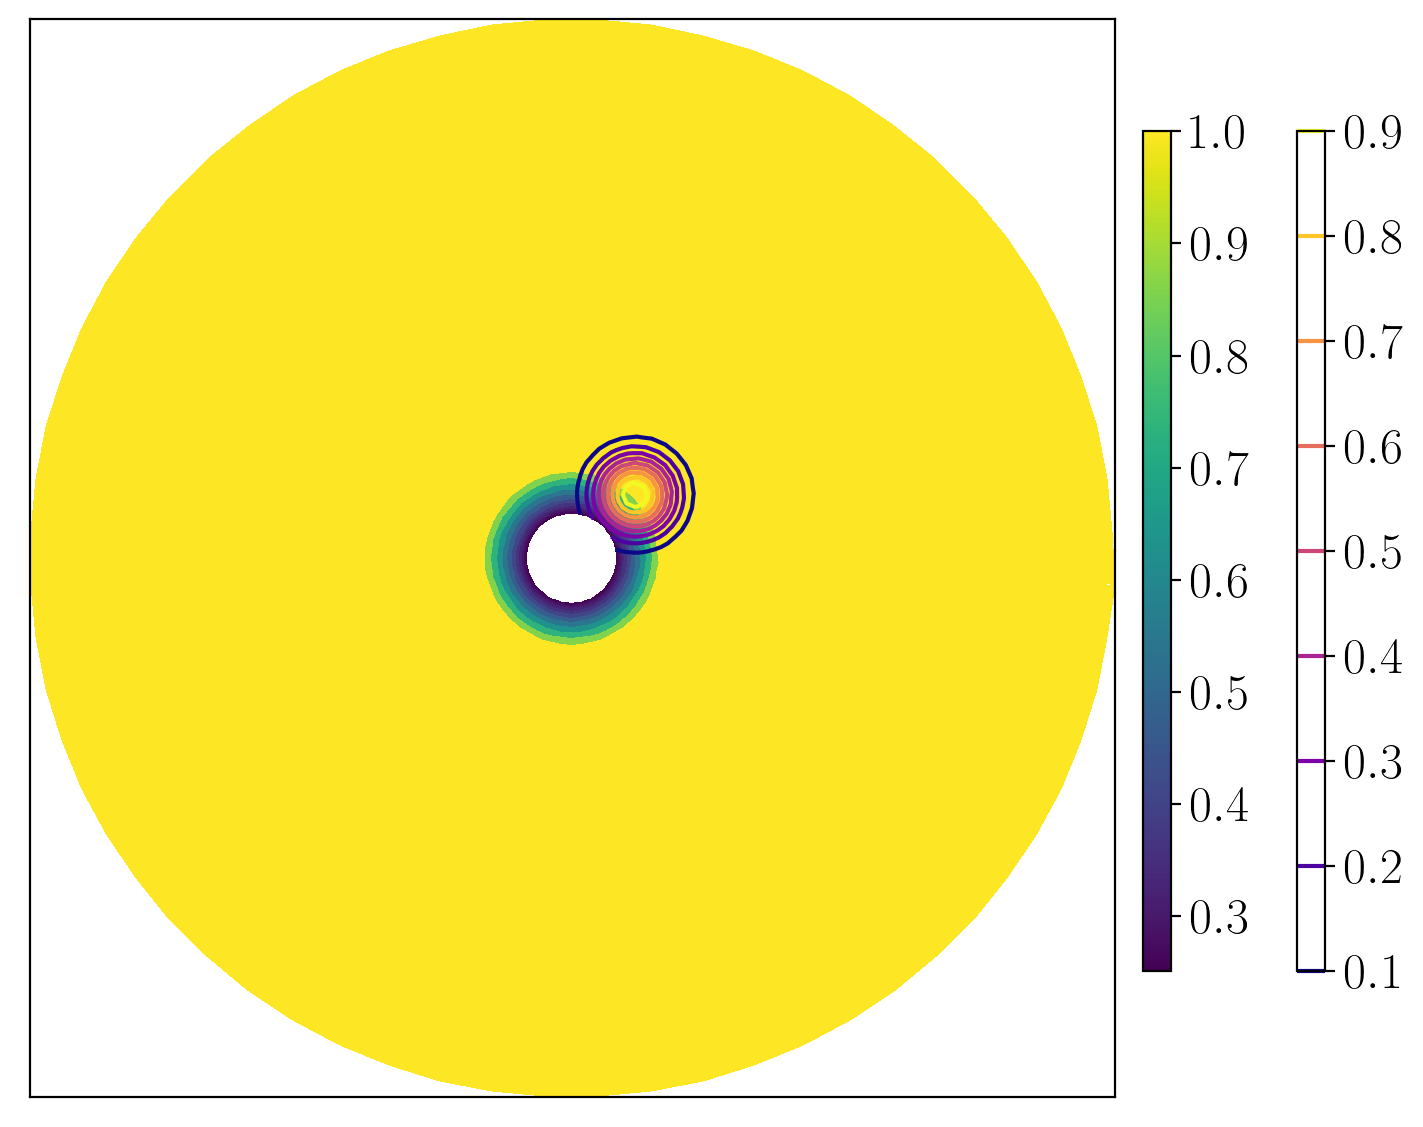

In [48]:
# gaussian eman pumping (spatial distribution)
r0 = 1; θ0 = np.pi/4; σ = 0.3;
gaussian = np.exp(-(x-r0*np.cos(θ0))**2/(2*σ**2) - (y-r0*np.sin(θ0))**2/(2*σ**2));


## plot fields
fig,(ax) = plt.subplots(1,1, figsize=(7,7))
c=ax.pcolormesh(x,y,1/hinv['g'].real)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
f = ax.contour(x,y,gaussian, levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], cmap='plasma')
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.set_xticks([]);ax.set_yticks([])
cax = fig.add_axes([1.03, 0.2, 0.02, 0.6])
cbar=plt.colorbar(f,cax = cax,orientation='vertical',shrink = 0.5)
plt.show()

In [49]:
## forcing
Wek_spatial = dist.Field(bases=(θ_basis,r_basis))
Wek_spatial['g'] = ek_mag * gaussian 
Wek = Wek_spatial * np.exp(1j * ω_force * coriolis * t)

In [51]:
## problem
problem = d3.IVP([ψ, tau1, tau2], time=t, namespace=locals())
problem.add_equation("dt(ζ) + coriolis*(skew(grad(ψ))@grad(hinv)) +tau_terms = -κ*hinv*div(hinv*grad(ψ)) + Wek")
# problem.add_equation("dt(ζ) + coriolis*(skew(grad(ψ))*grad(hinv)) +tau_terms = -κ*hinv*grad(hinv*grad(ψ)) + Wek")
problem.add_equation("ψ(r=Ri)=0") #inner BC
problem.add_equation("ψ(r=Ro)=0") #inner BC



ValueError: Objects are not all equal.

In [80]:
## substitutions
dθ = lambda A: d3.Differentiate(A, coords['θ'])
dr = lambda A: d3.Differentiate(A, coords['r'])
θ, r = dist.local_grids(θ_basis, r_basis)
rinv = dist.Field(bases=r_basis); rinv['g'] = r**(-1)
lift_basis = r_basis.derivative_basis(2)
tau_terms = d3.Lift(tau1, lift_basis, -1) + d3.Lift(tau2, lift_basis, -2)
m_func = lambda m: abs(m)
abs_m = lambda A: abs_m_cls(A, coords['θ']) #note this implements the Dirichlet-to-Neumann BC

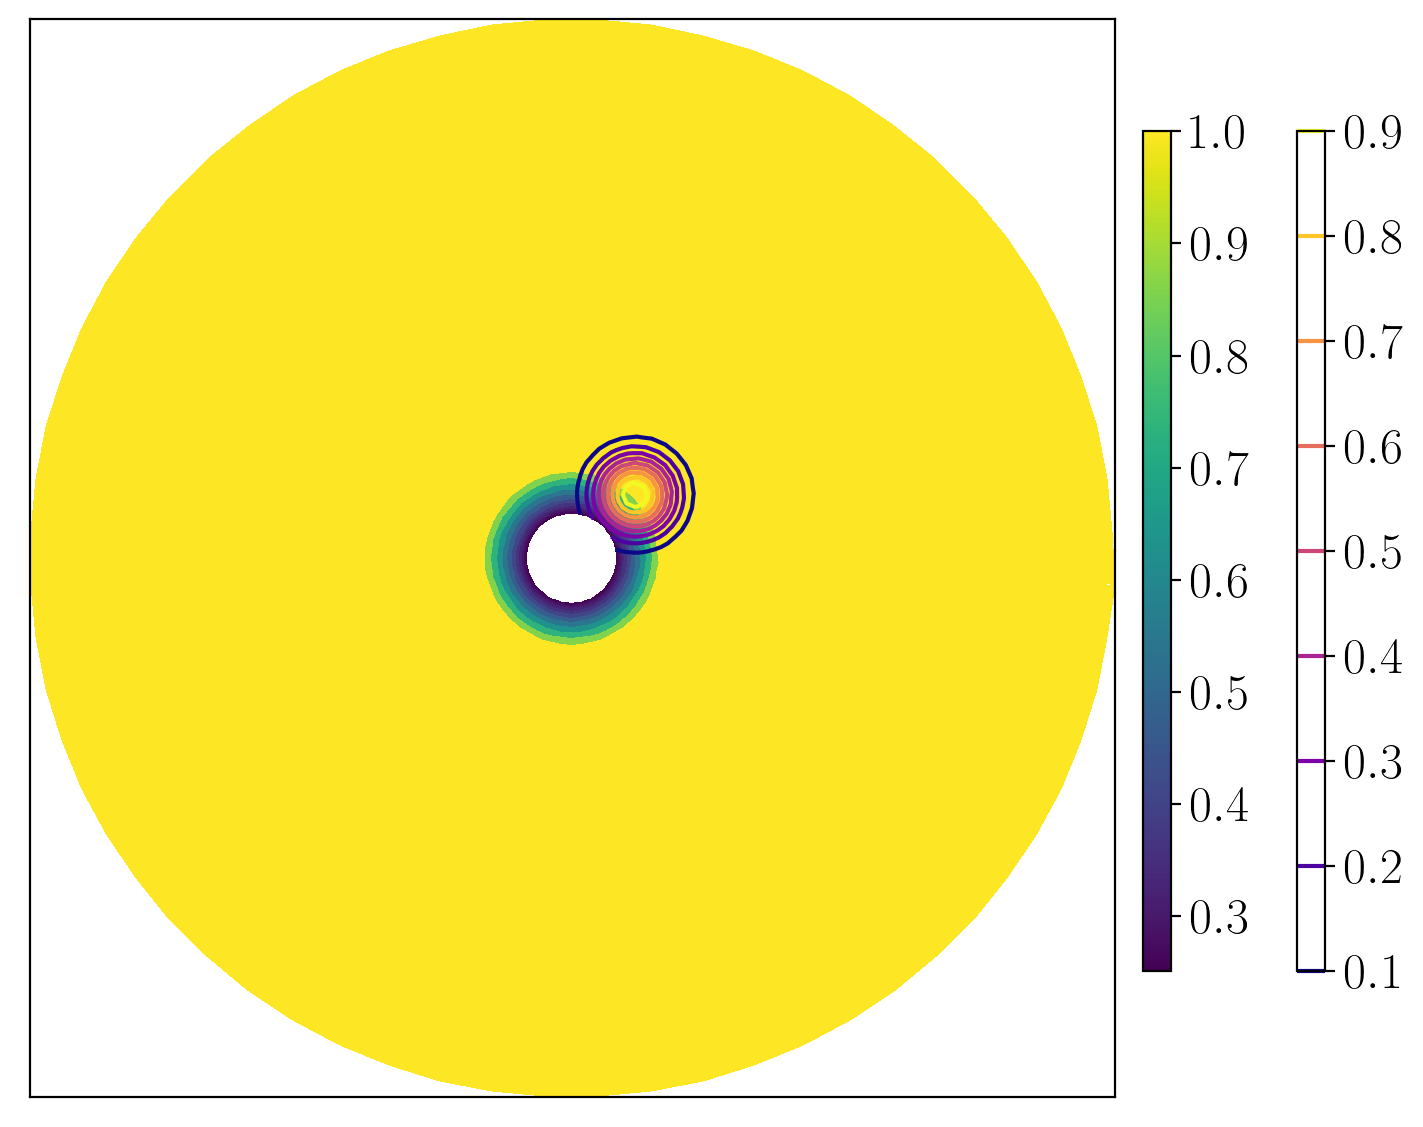

In [81]:
R,THETA = np.meshgrid(r,θ)
x = R*np.cos(THETA); y=R*np.sin(THETA)

# bathymetry
hisland = R**(2*α) 
hisland[hisland>1] = 1
hinv = dist.Field(bases=(θ_basis,r_basis))
hinv['g'] = hisland**(-1)

# gaussian eman pumping (spatial distribution)
r0 = 1; θ0 = np.pi/4; σ = 0.3;
gaussian = np.exp(-(x-r0*np.cos(θ0))**2/(2*σ**2) - (y-r0*np.sin(θ0))**2/(2*σ**2));


## plot fields
fig,(ax) = plt.subplots(1,1, figsize=(7,7))
c=ax.pcolormesh(x,y,1/hinv['g'].real)
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
f = ax.contour(x,y,gaussian, levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], cmap='plasma')
cbar=plt.colorbar(c,cax = cax,orientation='vertical',shrink = 0.5)
ax.set_xticks([]);ax.set_yticks([])
cax = fig.add_axes([1.03, 0.2, 0.02, 0.6])
cbar=plt.colorbar(f,cax = cax,orientation='vertical',shrink = 0.5)
plt.show()

In [83]:
## forcing
Wek_spatial = dist.Field(bases=(θ_basis,r_basis))
Wek_spatial['g'] = ek_mag * gaussian 
Wek = Wek_spatial * np.exp(1j * ω_force * coriolis * t)

In [86]:
## problem
problem = d3.IVP([ψ, tau1, tau2], time=t, namespace=locals())
problem.add_equation("hinv*dt(dr(dr(ψ))) + hinv*rinv*rinv*dt(dθ(dθ(ψ))) + dr(hinv)*dt(dr(ψ)) + rinv*rinv*dθ(hinv)*dt(dθ(ψ)) + coriolis*rinv*dθ(hinv)*dr(ψ) - coriolis*rinv*dr(hinv)*dθ(ψ) + tau_terms = -κ*hinv*(hinv*dr(dr(ψ)) + hinv*rinv*rinv*dθ(dθ(ψ)) + dr(hinv)*dr(ψ) + rinv*rinv*dθ(hinv)*dθ(ψ)) + Wek")
problem.add_equation("ψ(r=Ri)=0") #inner BC
problem.add_equation("ψ(r=Ro)=0") #inner BC
# problem.add_equation("integ(ψ) = 0") # Pressure gauge



In [87]:
## solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

ValueError: need at least one array to concatenate

In [ ]:
## dissipation

In [61]:
Wek * np.exp(1j * ω_force * f * t)

Mul(<Field 5157581344>, exp(Mul(-2.7000000000000002e-05j, <Field 5109148752>)))

In [ ]:
u0_real = dist.VectorField(coords, bases=disk)
u0_imag = dist.VectorField(coords, bases=disk)
u0_real['g'][0] = Ro * np.real(jv(1, (1-1j)*r/np.sqrt(2*Ekman)) / jv(1, (1-1j)/np.sqrt(2*Ekman)))
u0_imag['g'][0] = Ro * np.imag(jv(1, (1-1j)*r/np.sqrt(2*Ekman)) / jv(1, (1-1j)/np.sqrt(2*Ekman)))
t = dist.Field()
u0 = np.cos(t) * u0_real - np.sin(t) * u0_imag


In [52]:
 np.exp(1j * ω_force * f * t)

exp(Mul(-2.7000000000000002e-05j, <Field 5109148752>))

In [60]:
jv(1, (1-1j)*r/np.sqrt(2*1e-4))

array([[-5.42708258e+13+1.17776890e+14j, -8.68718169e+13+1.26419409e+14j,
        -1.73524185e+14+1.26147321e+14j, -3.51984515e+14+4.22365309e+13j,
        -5.86674508e+14-3.65832235e+14j, -2.68899223e+14-1.56609944e+15j,
         3.19100528e+15-2.87581667e+15j,  1.23560766e+16+5.75060017e+15j,
        -9.69790624e+15+4.96745722e+16j, -2.18120661e+17-2.31510278e+16j,
         1.87961968e+17-1.08951673e+18j,  5.98658079e+18+2.41995570e+18j,
        -2.93874456e+19+3.20956899e+19j, -1.10099952e+20-3.18409331e+20j,
         2.85055603e+21+8.75201911e+20j, -2.61510862e+22+1.47346677e+22j,
         1.23611370e+23-3.18630946e+23j,  8.69734620e+23+4.28878748e+24j,
        -3.83471764e+25-4.95163427e+25j,  8.44590790e+26+5.26898375e+26j,
        -1.66675897e+28-5.18877377e+27j,  3.32270578e+29+4.57977007e+28j,
        -7.00020385e+30-3.93196045e+29j,  1.58066989e+32+8.20278250e+30j,
        -3.80403181e+33-4.45662378e+32j,  9.56911588e+34+2.36925437e+34j,
        -2.44262229e+36-1.09738501e+36

In [59]:
from scipy.special import jv


In [ ]:
## 

In [ ]:
# Problem
problem = d3.EVP([Φ, tau1, tau2], eigenvalue=ωinv, namespace=locals())
problem.add_equation("Hinv*(dr(dr(Φ)) + rinv*dr(Φ) + rinv**2*dθ(dθ(Φ))) + dr(Φ)*dr(Hinv) + rinv**2*dθ(Φ)*dθ(Hinv) + 1j*rinv*ωinv*(dr(Φ)*dθ(Hinv) - dθ(Φ)*dr(Hinv)) + tau_terms = 0 ")
problem.add_equation("Φ(r=Ri)=0") #inner BC
problem.add_equation("dr(Φ)(r=Ro) + abs_m(Φ)(r=Ro) / Ro = 0") #outer BC


In [ ]:
# Parameters
Nphi, Nr = 32, 128
Ekman = 1 / 2 / 20**2
Ro = 40
dealias = 3/2
stop_sim_time = 50
timestepper = d3.SBDF2
timestep = 1e-3
dtype = np.float64

# Bases
coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
disk = d3.DiskBasis(coords, shape=(Nphi, Nr), radius=1, dealias=dealias, dtype=dtype)
edge = disk.edge

# Fields
u = dist.VectorField(coords, name='u', bases=disk)
p = dist.Field(name='p', bases=disk)
tau_u = dist.VectorField(coords, name='tau_u', bases=edge)
tau_p = dist.Field(name='tau_p')

# Substitutions
phi, r = dist.local_grids(disk)
nu = Ekman
lift = lambda A: d3.Lift(A, disk, -1)

# Background librating flow
u0_real = dist.VectorField(coords, bases=disk)
u0_imag = dist.VectorField(coords, bases=disk)
u0_real['g'][0] = Ro * np.real(jv(1, (1-1j)*r/np.sqrt(2*Ekman)) / jv(1, (1-1j)/np.sqrt(2*Ekman)))
u0_imag['g'][0] = Ro * np.imag(jv(1, (1-1j)*r/np.sqrt(2*Ekman)) / jv(1, (1-1j)/np.sqrt(2*Ekman)))
t = dist.Field()
u0 = np.cos(t) * u0_real - np.sin(t) * u0_imag

# Problem
problem = d3.IVP([p, u, tau_u, tau_p], time=t, namespace=locals())
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("dt(u) - nu*lap(u) + grad(p) + lift(tau_u) = - u@grad(u0) - u0@grad(u)")
problem.add_equation("u(r=1) = 0")
problem.add_equation("integ(p) = 0")
